## Setup

In [1]:
import pandas as pd
import random
import numpy as np
from matplotlib import pyplot as plt
from sre_constants import JUMP
import time

## Part 1

In [6]:
# Function to generate initial data
def genDf_prev():
  data = []
  for appNumber in range(100):
    # Determine what the characteristics of the applicant are
    x1Rng = random.random()
    x2Rng = random.random()

    adv = 'A' if appNumber > 49 else 'D'

    x1 = 0
    x2 = 0

    if adv == 'A':
      if x1Rng < 2/3:
        x1 = 1
      if x2Rng < 2/3:
        x2 = 1
    else:
      if x1Rng < 1/2:
        x1 = 1
      if x2Rng < 1/2:
        x2 = 1
    f = x1 * x2
    data.append([x1,x2,adv,f])

  df = pd.DataFrame(data, columns=['x1', 'x2', 'G', 'f']) # Create dataframe
  df['admitted'] = 0
  df = df.sample(frac = 1) #This shuffles around the dataframe and allows for tie breaking
  return df

In [8]:
# Function to generate initial data
def genDf(probA = 0.6667, probD = 0.3333):
  app_numbers = np.arange(100)
  G_values = np.where(app_numbers > 49, 'A', 'D')

  #assign the probabilities for X1 and X2 depending on the group
  probs = np.where(G_values == 'A', probA, probD)

  #calculate x1 and x2 based on probabilities
  x1 = np.random.random(len(probs)) < probs
  x2 = np.random.random(len(probs)) < probs

  #calculate f based on x1 and x2
  f = np.multiply(x1, x2) #x1 * x2

  data = pd.DataFrame({'x1':x1, 'x2':x2,'G':G_values, 'f':f, 'admitted':np.zeros(100)})
  data = data.sample(frac=1)

  return data




Time for 1000 iterations: 1.3071789741516113


Compare runtime of old and new genDF() functions

In [57]:
start_time = time.time()
for i in range(1000):
  df2 = genDf()
print("Time for 1000 iterations on new genDf():" , time.time() - start_time)

start_time = time.time()
for i in range(1000):
  df2 = genDf_prev()
print("Time for 1000 iterations on previous genDf():" , time.time() - start_time)

Time for 1000 iterations on new genDf(): 1.3981192111968994
Time for 1000 iterations on previous genDf(): 2.044285535812378


In [9]:
start_time= time.time()
for i in range(1000):
  df1 = genDf_prev()
print("Time for 1000 iterations:", time.time() - start_time)

Time for 1000 iterations: 2.949908494949341


In [10]:
# Consider x1 and x2, but not group membership
def run_scen_1(df):
  df = df.sort_values(by=['f'],ascending=False).reset_index(drop = True)
  df.loc[:27, 'admitted'] = 1
  return(df)


In [11]:
# Consider x1, but not x2 or group membership information
def run_scen_2(df):
  df = df.sort_values(by=['x1'],ascending=False).reset_index(drop = True)
  df.loc[:27, 'admitted'] = 1
  return(df)

In [12]:
# Consider x1 and group membership, but not x2
def run_scen_3(df):
  df['avg_f'] = np.where(df['x1']==0, 0,
                np.where((df['x1']==1) & (df['G']=='A'), 2/3, 1/3))

  df = df.sort_values(by=['avg_f'],ascending=False).reset_index(drop = True)
  df.loc[:27, 'admitted'] = 1
  return(df)

In [13]:
# Consider x1 for everyone, consider x2 for disadvantaged group, do not consider group info otherwise
def run_scen_4(df):
  df['avg_f'] = np.where((df['G']=='D') & (df['x1']==1) & (df['x2'] == 1), 1, #if the person is in the disadvantaged group, look at their x2 score also
                np.where((df['x1']== 1) & ((df['G'] == 'A') | ((df['G'] == 'D') & (df['x2'] == 0))), 1/2,  #if the person is in the advantaged group, OR disadvantaged with x2= 0
                0)) #if the person does not have even x1= 0,  average f must be 0

  df = df.sort_values(by=['avg_f'],ascending=False).reset_index(drop = True)
  df.loc[:27, 'admitted'] = 1
  return(df)

In [14]:
def compute_results(res):
  #subset to only admitted students
  admitted = res.loc[res['admitted'] == 1]
  #calculate percent of accepted applicants who are disadvantaged
  equity = len(admitted.loc[admitted['G'] == 'D']) / len(admitted)
  #print(res)
  #print("Equity (mean group value): ", equity)
  efficiency = admitted['f'].mean()
  #print("Efficiency (mean f value): ", admitted['admitted'].mean())

  return equity, efficiency

In [15]:
#Calculation for part 3 to determine the ratios of meaningful employment.
def compute_employment_dist(res):
    emp_A = [] #Store employment odds based on advantage group and admissions status.
    emp_D = []
    emp_admit = []
    emp_no_admit = []
    for row in range(len(res)):
        emp_odds = 0
        if (res.loc[row]['G'] == 'A'):
          emp_odds = emp_odds + .25
        if (res.loc[row]['x1'] == 1):
          emp_odds = emp_odds + .5
        if (res.loc[row]['x2'] == 1):
          emp_odds = emp_odds + .25

        emp_odds = min(max(emp_odds,.05),.99)
        rng = random.uniform(0, 1) #begin simulating employment
        if (rng < emp_odds):
          emp_odds = 1
        else:
          emp_odds = 0 #end simulating employment
        if (res.loc[row]['G'] == 'A'):
            emp_A.append(emp_odds)
        else:
            emp_D.append(emp_odds)
        if (res.loc[row]['admitted'] == 0):
            emp_no_admit.append(emp_odds)
        else:
            emp_admit.append(emp_odds)
    return([np.mean(emp_A),np.mean(emp_D),np.mean(emp_admit),np.mean(emp_no_admit), np.sum(emp_A)+np.sum(emp_D)])

In [16]:
#Definitions of fairness

#function to determine equal opportunity - probability of admission for each group should be same if they both have positive features
def equal_opportunity(df, threshold = 0.05, criteria = 1):
  #only consider x1 as a "positive trait"
  if criteria == 1:
    prob_accepted_d = df[(df['G'] == 'D') & (df['x1'] == 1)]['admitted'].mean()
    prob_accepted_a = df[(df['G'] == 'A') & (df['x1'] == 1)]['admitted'].mean()

  #if 2 or any other value are passed, consider a "positive trait" to be both x1 and x2 and calculate the probability of being admitted
  else:
    prob_accepted_d = df[(df['G'] == 'D') & (df['x1'] == 1) & (df['x2'] == 1)]['admitted'].mean()
    prob_accepted_a = df[(df['G'] == 'A') & (df['x1'] == 1) & (df['x2'] == 1)]['admitted'].mean()

  ret_val = prob_accepted_a - prob_accepted_d

  return ret_val

#take the list of results from many attempts and summarize the findings into a string
def equal_opportunity_summary(equal_opp_list):

  results = np.round(np.mean(equal_opp_list), decimals = 3)

  return results


In [17]:
#function takes a function (1 of 4 scenarios) as the first parameter, then the population to calculate on, and 2 lists to store the results
def scenario_repeated(func, population, equity_list, efficiency_list, employment_list, equalopp_list1, equalopp_list2):
  #first call the appropriate scenario function
  result_df = func(population)

  #calculate the efficiency and equity
  eq, eff = compute_results(result_df)
  emp_vector = compute_employment_dist(result_df) #Addition for part 3

  #calculate equal opportunity
  equalopp1 = equal_opportunity(result_df, criteria = 1)
  equalopp2 = equal_opportunity(result_df, criteria = 2)

  #append to lists (passed by reference)
  equity_list.append(eq)
  efficiency_list.append(eff)
  employment_list.append(emp_vector)
  equalopp_list1.append(equalopp1)
  equalopp_list2.append(equalopp2)


#create empty lists to save repeated calculations of the efficiency and equity scores
scen1_equity = []
scen1_efficiency = []
scen2_equity = []
scen2_efficiency = []
scen3_equity = []
scen3_efficiency = []
scen4_equity = []
scen4_efficiency = []

#create empty lists to save calculations of employment rates
scen1_employment = [[]]
scen2_employment = [[]]
scen3_employment = [[]]
scen4_employment = [[]]

#create empty lists to save calculations of equal opportunity rates (for criteria = 1 and criteria = 2)
scen1_equalopp1 = []
scen2_equalopp1 = []
scen3_equalopp1 = []
scen4_equalopp1 = []
scen1_equalopp2 = []
scen2_equalopp2 = []
scen3_equalopp2 = []
scen4_equalopp2 = []

#calculate equity and efficiency for all 4 scenarios repeatedly
for i in range(100):
  population = genDf()

  scenario_repeated(run_scen_1, population, scen1_equity, scen1_efficiency, scen1_employment, scen1_equalopp1, scen1_equalopp2)
  scenario_repeated(run_scen_2, population, scen2_equity, scen2_efficiency, scen2_employment, scen2_equalopp1, scen2_equalopp2)
  scenario_repeated(run_scen_3, population, scen3_equity, scen3_efficiency, scen3_employment, scen3_equalopp1, scen3_equalopp2)
  scenario_repeated(run_scen_4, population, scen4_equity, scen4_efficiency, scen4_employment, scen4_equalopp1, scen4_equalopp2)


#Print results
print("Scenario 1 Efficiency: {} , Equity: {}".format(np.mean(scen1_efficiency), np.mean(scen1_equity)))
print("Scenario 2 Efficiency: {} , Equity: {}".format(np.mean(scen2_efficiency), np.mean(scen2_equity)))
print("Scenario 3 Efficiency: {} , Equity: {}".format(np.mean(scen3_efficiency), np.mean(scen3_equity)))
print("Scenario 4 Efficiency: {} , Equity: {}".format(np.mean(scen4_efficiency), np.mean(scen4_equity)))
print("Results for part 3:") #Print results for part 3
#print("Scenario 1 Employment by group: {}".format(np.mean(scen1_employment)))
scen1_employment.pop(0)
scen2_employment.pop(0)
scen3_employment.pop(0)
scen4_employment.pop(0)
print("Scenario 1 Employment Stats (A, D, Admit, No Admit): {}".format(np.mean(scen1_employment, axis=0)))
print("Scenario 2 Employment Stats (A, D, Admit, No Admit): {}".format(np.mean(scen2_employment, axis=0)))
print("Scenario 3 Employment Stats (A, D, Admit, No Admit): {}".format(np.mean(scen3_employment, axis=0)))
print("Scenario 4 Employment Stats (A, D, Admit, No Admit): {}".format(np.mean(scen4_employment, axis=0)))

print("\n Equal Opportunity (Definition of Fairness): positive scores favor disadvantaged group")
print("Scenario 1, using x1 as positive group: ", equal_opportunity_summary(scen1_equalopp1))
print("Scenario 1, using x1 and x2 as positive group: ", equal_opportunity_summary(scen1_equalopp2))
print("Scenario 2, using x1 as positive group: ", equal_opportunity_summary(scen2_equalopp1))
print("Scenario 2, using x1 and x2 as positive group: ", equal_opportunity_summary(scen2_equalopp2))
print("Scenario 3, using x1 as positive group: ", equal_opportunity_summary(scen3_equalopp1))
print("Scenario 3, using x1 and x2 as positive group: ", equal_opportunity_summary(scen3_equalopp2))
print("Scenario 4, using x1 as positive group: ", equal_opportunity_summary(scen4_equalopp1))
print("Scenario 4, using x1 and x2 as positive group: ", equal_opportunity_summary(scen4_equalopp2))

Scenario 1 Efficiency: 0.9285714285714285 , Equity: 0.23642857142857143
Scenario 2 Efficiency: 0.547142857142857 , Equity: 0.3257142857142857
Scenario 3 Efficiency: 0.6414285714285713 , Equity: 0.003214285714285714
Scenario 4 Efficiency: 0.6000000000000001 , Equity: 0.3946428571428571
Results for part 3:
Scenario 1 Employment Stats (A, D, Admit, No Admit): [ 0.7424      0.2686      0.89785714  0.35291667 50.55      ]
Scenario 2 Employment Stats (A, D, Admit, No Admit): [ 0.749       0.2782      0.80428571  0.40055556 51.36      ]
Scenario 3 Employment Stats (A, D, Admit, No Admit): [ 0.7536      0.2788      0.90892857  0.36347222 51.62      ]
Scenario 4 Employment Stats (A, D, Admit, No Admit): [ 0.7516      0.2706      0.80071429  0.39847222 51.11      ]

 Equal Opportunity (Definition of Fairness): positive scores favor disadvantaged group
Scenario 1, using x1 as positive group:  0.283
Scenario 1, using x1 and x2 as positive group:  -0.002
Scenario 2, using x1 as positive group:  0.0

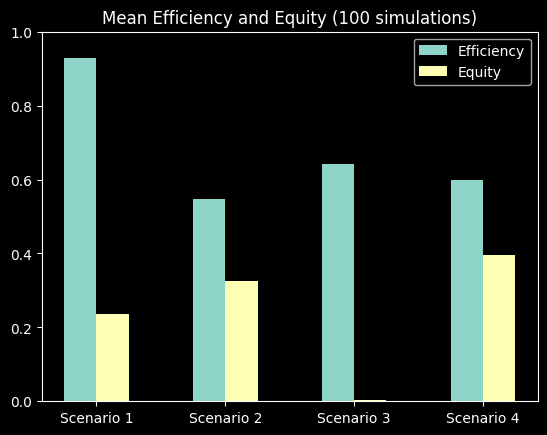

In [18]:
# Creating plots for Part 1
plt.style.use('dark_background')

# Bar chart of average efficiency and equity scores across scenarios
results_dict_pt1 = {'Scenario 1': {'Equity': scen1_equity, 'Efficiency': scen1_efficiency},
                    'Scenario 2': {'Equity': scen2_equity, 'Efficiency': scen2_efficiency},
                    'Scenario 3': {'Equity': scen3_equity, 'Efficiency': scen3_efficiency},
                    'Scenario 4': {'Equity': scen4_equity, 'Efficiency': scen4_efficiency}}

plt.bar([1,2,3,4], [np.mean(each['Efficiency']) for each in results_dict_pt1.values()], width = 0.25, label = 'Efficiency')
plt.bar([1.25, 2.25, 3.25, 4.25], [np.mean(each['Equity']) for each in results_dict_pt1.values()], width = 0.25, label = 'Equity')
plt.title('Mean Efficiency and Equity (100 simulations)')
plt.xticks([1.125,2.125,3.125,4.125], results_dict_pt1.keys())
plt.legend(loc='upper right')
plt.ylim(0, 1)
# plt.close()

# Line chart of efficiency and equity scores across repeated runs
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)

for each in results_dict_pt1.keys():
  ax1.plot(np.arange(len(results_dict_pt1[each]['Equity'])), results_dict_pt1[each]['Equity'], label = each)
  ax2.plot(np.arange(len(results_dict_pt1[each]['Efficiency'])), results_dict_pt1[each]['Efficiency'])

plt.setp(ax1, ylim=(0,1))
plt.setp(ax2, ylim=(0,1))
ax1.set_title('Equity Across 100 Simulations')
ax2.set_title('Efficiency Across 100 Simulations')
ax1.set_xlabel('Simulation Index')
ax2.set_xlabel('Simulation Index')
ax1.set_ylabel('Equity')
ax2.set_ylabel('Efficiency')
fig.legend(loc='upper right')
plt.close()



Text(0, 0.5, 'Prob. Accepted | Positive Criteria \n (Advantaged - Disadvantaged)')

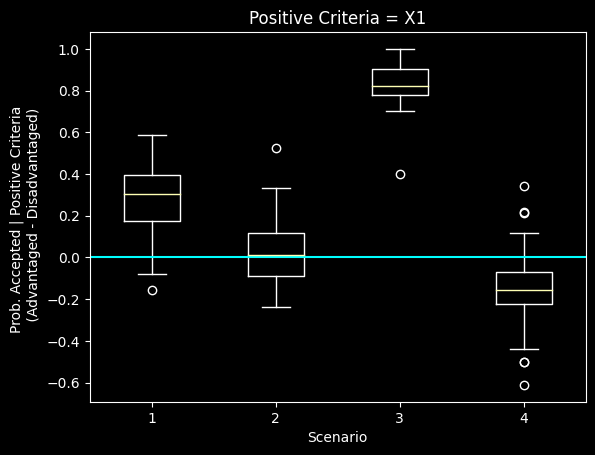

In [19]:
#create plots showing the difference in equal opportunity fairness definition
plt.style.use('dark_background')

all_criteria1 = [scen1_equalopp1, scen2_equalopp1, scen3_equalopp1, scen4_equalopp1]
plt.boxplot(all_criteria1)
plt.axhline(y=0, color='cyan')
plt.title('Positive Criteria = X1')
plt.xlabel('Scenario')
plt.ylabel('Prob. Accepted | Positive Criteria \n (Advantaged - Disadvantaged)')
#plt.close()

#all_criteria2 = [scen1_equalopp2, scen2_equalopp2, scen3_equalopp2, scen4_equalopp2]
#plt.boxplot(all_criteria2)
#plt.axhline(y=0, color='cyan')
##plt.title('Positive Criteria = X1 & X2')
#plt.xlabel('Scenario')
#plt.ylabel('Prob. Accepted | Positive Criteria \n (Advantaged - Disadvantaged)')
#plt.close()

## Part 2

For the new generation -
* if the parent is in the advantaged group:
  * if the parent was admitted to college, the child is certainly in the advantaged group.
  * if the parent was not admitted to college, the child has a 25% change of changing to the disadvantaged group
* if the parent is in the disadvantaged group:
  * if the parent was admitted to college, the child has a 50% chance of changing to the advantaged group
  * if the parent was not admitted to college, the child is certainly in the disadvantaged group.

In [48]:
import warnings
warnings.simplefilter(action='ignore')

def nextGeneration_prev(df):
    nextGen = df.copy(deep=True)

    # use probabilities to determine if any children will switch groups
    for row in range(len(df)):
        if (nextGen.loc[row]['admitted'] == 1) and (nextGen.loc[row]['G'] == 'D'):
            rng = random.random()
            if rng < .1:
                nextGen['G'][row] = 'A'
        if (nextGen.loc[row]['admitted'] == 0) and (nextGen.loc[row]['G'] == 'A'):
            rng = random.random()
            if rng < .1:
                nextGen['G'][row] = 'D'

    # determine x1, x2, and f values for all children according to the probabilities assigned to their groups
    for row in range(len(df)):
        x1Rng = random.random()
        x2Rng = random.random()
        adv = nextGen['G'][row]
        if adv == 'A':
            if x1Rng < 2/3:
                nextGen['x1'][row] = 1
            else:
                nextGen['x1'][row] = 0
            if x2Rng < 2/3:
                nextGen['x2'][row] = 1
            else:
                nextGen['x2'][row] = 0
        else:
            if x1Rng < 1/2:
                nextGen['x1'][row] = 1
            else:
                nextGen['x1'][row] = 0
            if x2Rng < 1/2:
                nextGen['x2'][row] = 1
            else:
                nextGen['x2'][row] = 0
        f = (nextGen['x1'][row]) * (nextGen['x2'][row])
        nextGen['f'][row] = f

    # reset admitted values
    nextGen['admitted'] = 0

    #return a dataframe of the new generation
    return nextGen

In [49]:
# Function to generate initial data
def nextGeneration(df, probA = 0.6667, probD = 0.3333):

  #decide if anyone will switch groups
  switch_prob = np.random.random(len(df))
  #boolean list that indicates whether this person is moving up
  move_up = np.where((df['G'] == 'D') & (df['admitted'] == 1) & (switch_prob < 0.1), 1, 0)
  #boolean list that indicates whether this person is moving down
  move_down = np.where((df['G'] == 'A') & (df['admitted'] == 0) & (switch_prob < 0.1), 1, 0)
  #boolean list that indicates the group - considering if they moved up, down, or stayed the same
  new_G = np.where(move_up, 'A', np.where(move_down, 'D', df['G']))


  #assign the probabilities for X1 and X2 depending on the group
  probs = np.where(new_G == 'A', probA, probD)

  #calculate x1 and x2 based on probabilities
  x1 = np.random.random(len(probs)) < probs
  x2 = np.random.random(len(probs)) < probs

  #calculate f based on x1 and x2
  f = np.multiply(x1, x2)

  nextGen = pd.DataFrame({'x1':x1, 'x2':x2,'G': new_G, 'f':f, 'admitted':np.zeros(100)})
  nextGen = nextGen.sample(frac=1)

  return nextGen

Compare runtime of old code and new code:

In [47]:
admitted_df = run_scen_4(df2)

start_time = time.time()
for i in range(1000):
  df_test = nextGeneration(admitted_df)
print("Next Generation2 took {} for 1000 iterations".format(time.time() - start_time))

tart_time = time.time()
for i in range(1000):
  df_test = nextGeneration_prev(admitted_df)
print("Next Generation1 took {} for 1000 iterations".format(time.time() - start_time))

Next Generation2 took 1.5743463039398193 for 1000 iterations
Next Generation1 took 33.56583619117737 for 1000 iterations


Create 100 new generations and calculate efficiency and equity over time

In [50]:
start_time = time.time()

num_generations = 100
num_repeats = 3

# Create empty list to store dataframes
generation_dfs = [[[], [], [], []] for i in range(num_repeats)]

# Create list of functions to run
scen_func = [run_scen_1, run_scen_2, run_scen_3, run_scen_4]

#repeat with different random starting generations
for rep in range(num_repeats):

  # Run simulation for each scenario
  for each in range(4):
    #initialize a starting generation
    this_generation = genDf()

    # Run admission scenario
    func = scen_func[each]

    #generate subsequent generations and calculate equity/efficiency for each scenario
    for gen in range(num_generations):
      results = func(this_generation)
      generation_dfs[rep][each].append(results)

      # update this generation by creating a new generation
      this_generation = nextGeneration(results)

  print(rep)


print("Execution Time = ", time.time() - start_time)

0
1
2
Execution Time =  4.3331286907196045


In [51]:
# Calculate efficiency, equity, and employment stats for each df
equities = [[[compute_results(df)[0] for df in scenario_list] for scenario_list in rep_list] for rep_list in generation_dfs]
efficiencies = [[[compute_results(df)[1] for df in scenario_list] for scenario_list in rep_list] for rep_list in generation_dfs]
employment = [[[compute_employment_dist(df) for df in scenario_list] for scenario_list in rep_list] for rep_list in generation_dfs]
disadv_count = [[[len(df.loc[df['G'] == 'D']) for df in scenario_list] for scenario_list in rep_list] for rep_list in generation_dfs]

In [52]:
# Calculate means
mean_equities = []
mean_efficiences = []
mean_employment_a = []
mean_employment_d = []
mean_employment_admit = []
mean_employment_no_admit = []
mean_employment_total = []
mean_disadv_count = []

for each in range(4):
  mean_equities.append([np.mean([equities[0][each][gen], equities[1][each][gen], equities[2][each][gen]]) for gen in range(num_generations)])
  mean_efficiences.append([np.mean([efficiencies[0][each][gen], efficiencies[1][each][gen], efficiencies[2][each][gen]]) for gen in range(num_generations)])
  mean_disadv_count.append([np.mean([disadv_count[0][each][gen], disadv_count[1][each][gen], disadv_count[2][each][gen]]) for gen in range(num_generations)])
  mean_employment_a.append([np.mean([employment[0][each][gen][0], employment[1][each][gen][0], employment[2][each][gen][0]]) for gen in range(num_generations)])
  mean_employment_d.append([np.mean([employment[0][each][gen][1], employment[1][each][gen][1], employment[2][each][gen][1]]) for gen in range(num_generations)])
  mean_employment_admit.append([np.mean([employment[0][each][gen][2], employment[1][each][gen][2], employment[2][each][gen][2]]) for gen in range(num_generations)])
  mean_employment_no_admit.append([np.mean([employment[0][each][gen][3], employment[1][each][gen][3], employment[2][each][gen][3]]) for gen in range(num_generations)])
  mean_employment_total.append([np.mean([employment[0][each][gen][4], employment[1][each][gen][4], employment[2][each][gen][4]]) for gen in range(num_generations)])

### Problem 2 summary across generations:  

*   Scenario 1.   
  *  equity increases to 1 across generations (crosses 0.5 threshold by 3rd generation).  
  * efficiency decreases steadily across generations
*   Scenario 2.
  * equity increases to 1 across generations (crosses 0.5 threshold by 3rd generation).
  * efficiency decreases steadily across generations.
* Scenario 3.
  * equity increases to 1 across generations (crosses 0.5 threshold by 4th generation)
  * efficiency decreases steadily across generations.  
* Scenario 4.  
  * equity increases to 1 across generations. (crosses ~0.5 threshold by 2nd generation)
  * efficiency remains approximately the same.  



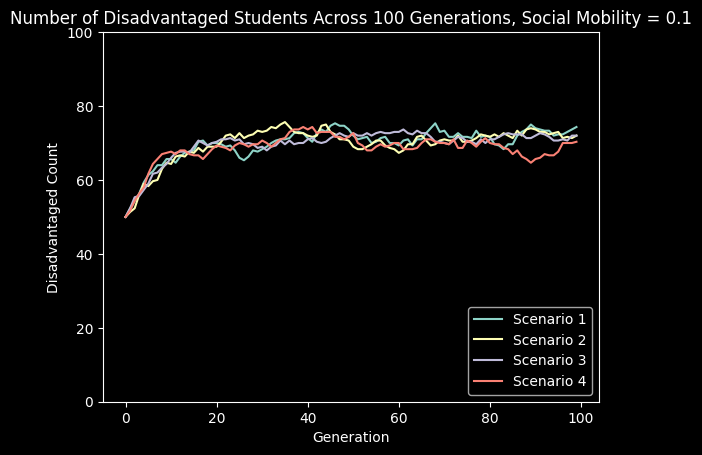

In [53]:
# Creating plots for Part 2

# Line chart of efficiency scores across generations
for each in range(4):
  plt.plot(np.arange(len(mean_efficiences[each])), mean_efficiences[each], label = f'Scenario {each+1}')

plt.ylim(0,1.05)
plt.title('Efficiency Across 100 Generations, Social Mobility = 0.1')
plt.xlabel('Generation')
plt.ylabel('Efficiency')
plt.legend(loc='lower right')
plt.close()

# Line chart of equity scores across generations
for each in range(4):
  plt.plot(np.arange(len(mean_equities[each])), mean_equities[each], label = f'Scenario {each+1}')

plt.ylim(0,1.05)
plt.title('Equity Across 100 Generations, Social Mobility = 0.1')
plt.xlabel('Generation')
plt.ylabel('Equity')
plt.legend(loc='upper right')
plt.close()

# Line chart of disadvantage group count across generations
for each in range(4):
  plt.plot(np.arange(len(mean_disadv_count[each])), mean_disadv_count[each], label = f'Scenario {each+1}')

plt.ylim(0,100)
plt.title('Number of Disadvantaged Students Across 100 Generations, Social Mobility = 0.1')
plt.xlabel('Generation')
plt.ylabel('Disadvantaged Count')
plt.legend(loc='lower right')
# plt.close()



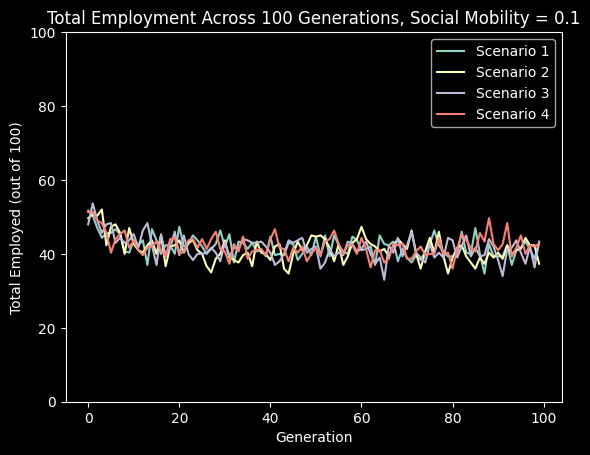

In [55]:
# Creating plots for Part 3
# Line chart of employment for each group across generations
fig, axs = plt.subplots(2, 2, layout = 'constrained')

axs[0,0].plot(np.arange(len(mean_employment_a[0])), mean_employment_a[0], label = 'Advantaged')
axs[0,0].plot(np.arange(len(mean_employment_d[0])), mean_employment_d[0], label = 'Disadvantaged')
axs[0,1].plot(np.arange(len(mean_employment_a[1])), mean_employment_a[1])
axs[0,1].plot(np.arange(len(mean_employment_d[1])), mean_employment_d[1])
axs[1,0].plot(np.arange(len(mean_employment_a[2])), mean_employment_a[2])
axs[1,0].plot(np.arange(len(mean_employment_d[2])), mean_employment_d[2])
axs[1,1].plot(np.arange(len(mean_employment_a[3])), mean_employment_a[3])
axs[1,1].plot(np.arange(len(mean_employment_d[3])), mean_employment_d[3])

axs[0,0].set_title("Scenario 1")
axs[0,1].set_title("Scenario 2")
axs[1,0].set_title("Scenario 3")
axs[1,1].set_title("Scenario 4")

axs[0,0].set_ylabel("Proportion Employed")
axs[1,0].set_ylabel("Proportion Employed")
axs[1,0].set_xlabel("Generation")
axs[1,1].set_xlabel("Generation")

axs[0,0].set_ylim(0,1)
axs[0,1].set_ylim(0,1)
axs[1,0].set_ylim(0,1)
axs[1,1].set_ylim(0,1)

fig.suptitle('Proportion Employed Across 100 Generations, Social Mobility = 0.1')
fig.legend(loc='outside lower center')
plt.close()

# Bar chart chart of proportion employed across scenarios, gen 1
results_dict_pt3 = {'Scenario 1': {'adv': np.mean(scen1_employment, axis=0)[0], 'disadv': np.mean(scen1_employment, axis=0)[1]},
                    'Scenario 2': {'adv': np.mean(scen2_employment, axis=0)[0], 'disadv': np.mean(scen1_employment, axis=0)[1]},
                    'Scenario 3': {'adv': np.mean(scen3_employment, axis=0)[0], 'disadv': np.mean(scen1_employment, axis=0)[1]},
                    'Scenario 4': {'adv': np.mean(scen4_employment, axis=0)[0], 'disadv': np.mean(scen1_employment, axis=0)[1]}}

plt.bar([1,2,3,4], [np.mean(each['disadv']) for each in results_dict_pt3.values()], width = 0.25, label = 'Disadvantaged')
plt.bar([1.25, 2.25, 3.25, 4.25], [np.mean(each['adv']) for each in results_dict_pt3.values()], width = 0.25, label = 'Advantaged')
plt.title('Mean Proportion of Employment by Group')
plt.xticks([1.125,2.125,3.125,4.125], results_dict_pt3.keys())
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.close()


# Line chart of equity scores across generations
for each in range(4):
  plt.plot(np.arange(len(mean_employment_total[each])), mean_employment_total[each], label = f'Scenario {each+1}')

plt.ylim(0,100)
plt.title('Total Employment Across 100 Generations, Social Mobility = 0.1')
plt.xlabel('Generation')
plt.ylabel('Total Employed (out of 100)')
plt.legend(loc='upper right')
plt.close()
